In [0]:
from fastai.vision import *

In [0]:
# Creating two directories - "data" and "data/trainset_11classes_0_00000" 
!mkdir data && mkdir data/trainset_11classes_0_00000

# Downloading the ai-camp competition dataset
!wget -N https://ai-camp.s3-us-west-2.amazonaws.com/trainset_11classes_0_00000.zip
  
# Unzip the data into the folder "data/trainset_11classes_0_00000"
!unzip -qq -n trainset_11classes_0_00000.zip -d data/trainset_11classes_0_00000

# Switch directory to "data/trainset_11classes_0_00000" and show its content
!cd data/trainset_11classes_0_00000 && ls

mkdir: cannot create directory ‘data’: File exists
--2019-06-11 09:15:22--  https://ai-camp.s3-us-west-2.amazonaws.com/trainset_11classes_0_00000.zip
Resolving ai-camp.s3-us-west-2.amazonaws.com (ai-camp.s3-us-west-2.amazonaws.com)... 52.218.241.177
Connecting to ai-camp.s3-us-west-2.amazonaws.com (ai-camp.s3-us-west-2.amazonaws.com)|52.218.241.177|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘trainset_11classes_0_00000.zip’ not modified on server. Omitting download.

cleaned.csv  models  train  val


In [0]:
import os

base_dir = 'data/trainset_11classes_0_00000'

# Directory to our training data
train_folder = os.path.join(base_dir, 'train')

# Directory to our validation data
val_folder = os.path.join(base_dir, 'val')

In [0]:
# List folders and number of files
print("Directory, Number of files")
for root, subdirs, files in os.walk(base_dir):
    print(root, len(files))

Directory, Number of files
data/trainset_11classes_0_00000 1
data/trainset_11classes_0_00000/models 2
data/trainset_11classes_0_00000/train 0
data/trainset_11classes_0_00000/train/WarriorPose 93
data/trainset_11classes_0_00000/train/KungfuSalute 92
data/trainset_11classes_0_00000/train/KoreanHeart 87
data/trainset_11classes_0_00000/train/HulkSmash 88
data/trainset_11classes_0_00000/train/HandShake 83
data/trainset_11classes_0_00000/train/ChildPose 81
data/trainset_11classes_0_00000/train/ChairPose 89
data/trainset_11classes_0_00000/train/KungfuCrane 88
data/trainset_11classes_0_00000/train/Dabbing 89
data/trainset_11classes_0_00000/train/Salute 90
data/trainset_11classes_0_00000/train/HandGun 93
data/trainset_11classes_0_00000/val 0
data/trainset_11classes_0_00000/val/WarriorPose 22
data/trainset_11classes_0_00000/val/KungfuSalute 25
data/trainset_11classes_0_00000/val/KoreanHeart 22
data/trainset_11classes_0_00000/val/HulkSmash 24
data/trainset_11classes_0_00000/val/HandShake 21
data/

In [0]:
np.random.seed(18)
data = ImageDataBunch.from_folder(base_dir, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

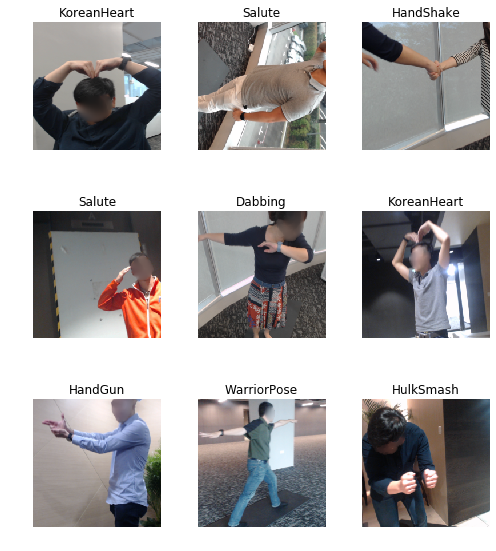

In [0]:
data.show_batch(rows=3, figsize=(7, 8))

In [0]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [0]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.722974,1.777274,0.591837,06:42
1,2.109131,1.234595,0.387755,06:43
2,1.667968,1.076112,0.318367,06:44
3,1.427784,1.064851,0.318367,06:43


In [0]:
learn.unfreeze() # must be done before calling lr_find

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


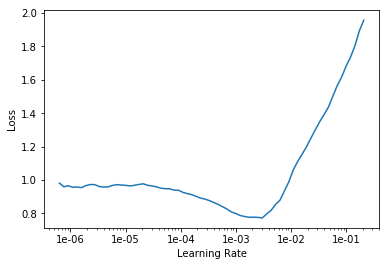

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(1e-04, 1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.928509,0.750009,0.253061,09:10
1,0.673738,0.604020,0.191837,09:11
2,0.489183,0.434157,0.151020,09:11
3,0.367611,0.403101,0.142857,09:12


In [0]:
learn.save('stage1')

In [0]:
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, base_dir)

In [0]:
import pandas as pd

df = pd.read_csv('data/trainset_11classes_0_00000/cleaned.csv', header='infer')
print(df.head())

db = (ImageList.from_df(df, base_dir)
                   .random_split_by_pct(0.2)
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch(bs=8)).normalize(imagenet_stats)

                               name        label
0  train/WarriorPose/226011_101.png  WarriorPose
1   train/WarriorPose/537975_47.png  WarriorPose
2    train/WarriorPose/100300_1.png  WarriorPose
3  train/WarriorPose/398142_108.png  WarriorPose
4   train/WarriorPose/765621_47.png  WarriorPose


/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:203: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [0]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))
print(db.classes, db.c, len(db.train_ds), len(db.valid_ds))

['ChairPose', 'ChildPose', 'Dabbing', 'HandGun', 'HandShake', 'HulkSmash', 'KoreanHeart', 'KungfuCrane', 'KungfuSalute', 'Salute', 'WarriorPose'] 11 981 245
['ChairPose', 'ChildPose', 'Dabbing', 'HandGun', 'HandShake', 'HulkSmash', 'KoreanHeart', 'KungfuCrane', 'KungfuSalute', 'Salute', 'WarriorPose'] 11 785 196


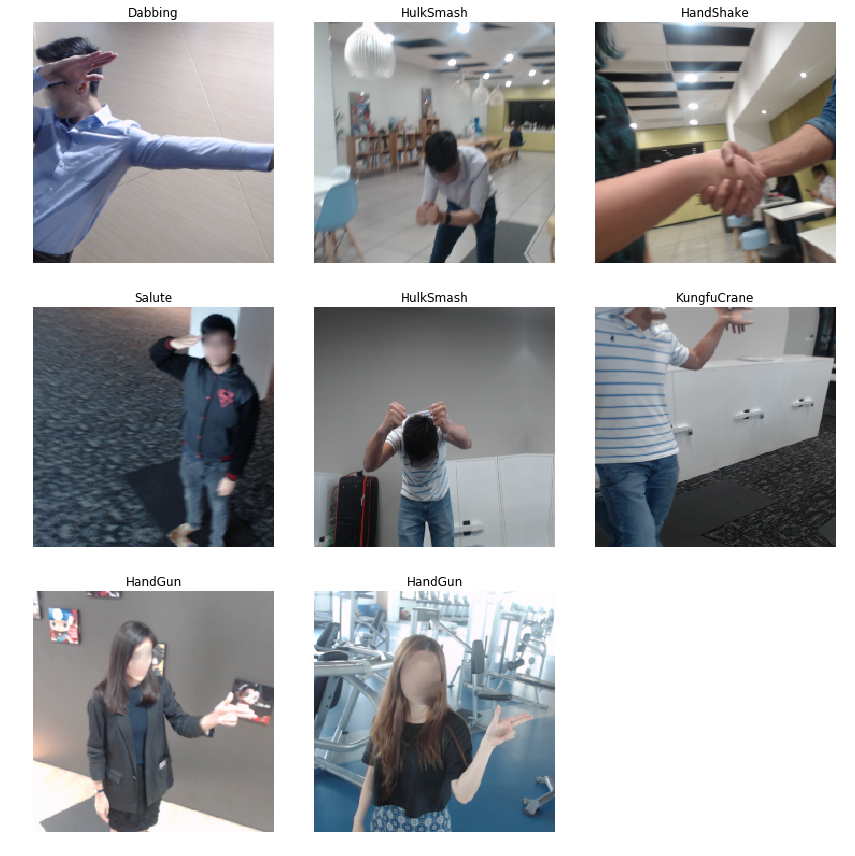

In [0]:
db.show_batch()

epoch,train_loss,valid_loss,error_rate,time
0,0.425209,0.077924,0.020408,05:34
1,0.463314,0.095410,0.035714,05:34
2,0.354673,0.115148,0.030612,05:33
3,0.345365,0.100989,0.040816,05:33


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,time
0,0.712695,1.102680,0.321429,07:59
1,1.415450,1.051317,0.311224,08:01
2,0.958113,0.524019,0.183673,08:02
3,0.562083,0.474138,0.158163,07:59


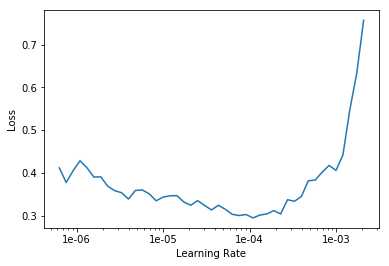

In [0]:
learn.load('stage1') # loading the weights
learn.data = db # replacing the data

learn.freeze()
learn.fit_one_cycle(4)

learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

learn.fit_one_cycle(4, max_lr=slice(1e-04, 1e-03))
learn.save('stage2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

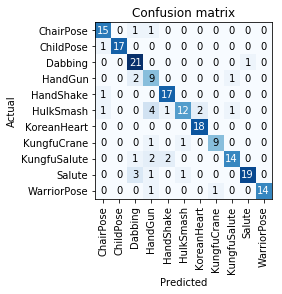

In [0]:
interp.plot_confusion_matrix()

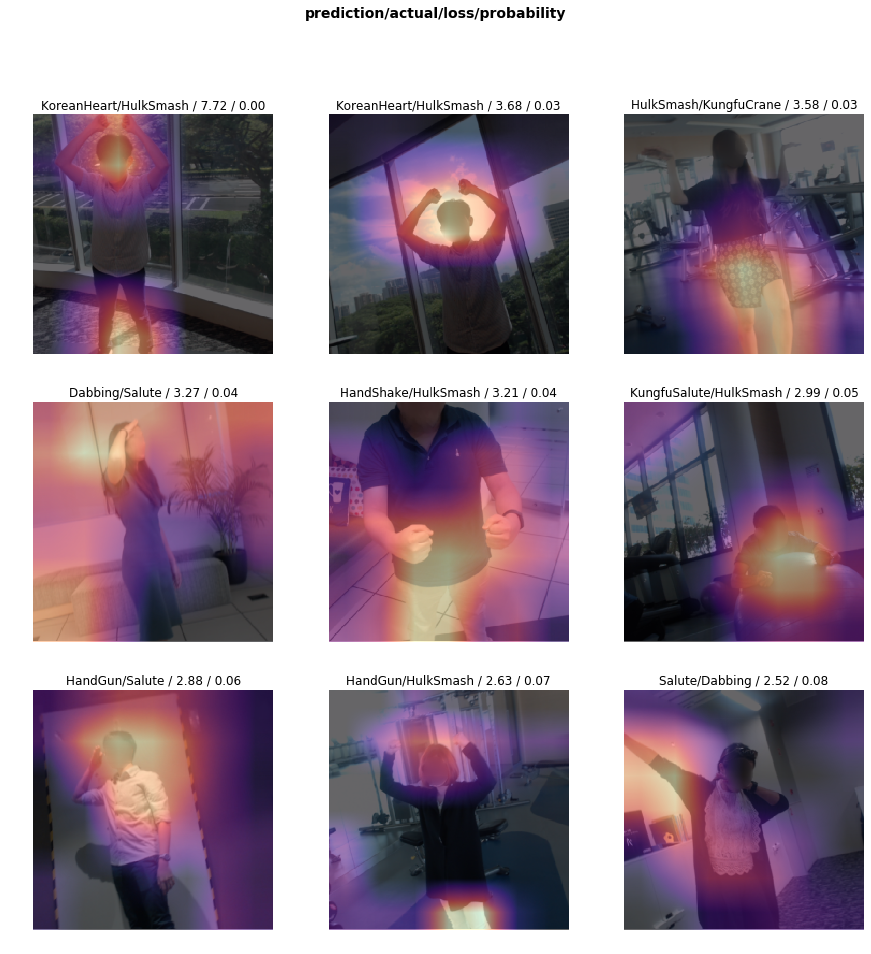

In [0]:
interp.plot_top_losses(9, figsize=(15,15))